# Setting up a basic simulation

In [1]:
#------ manually fix import
import sys
import pathlib

parent_folder = pathlib.Path().absolute().parents[0]
sys.path.append(str(parent_folder))
#------

import hcipy as hp
import numpy as np
import matplotlib.pyplot as plt
import obsim as obs

import astropy.units as u

In this notebook we will build a very simple simulation. Every simulation consists of three steps:
1. Defining the input sources
2. Defining the instrument and detector
3. Running the simulation

We start by defining the variables we will use:

In [2]:
lam = 1E-6 * u.m          # reference wavelength for telescope focal plane
F = 10                    # telescope F-number
D = 1 * u.m               # telescope diameter
fov = 10 * lam/D * u.rad  # telescope field of view
q = 8                     # pixels per lambda/d in focal plane

spectral_resolution = 1000  # spectral resolution of selected wavelengths  
spectral_band = 'R'         # spectral band for the selected wavelengths

# source locations
loc1 = np.array([2,1]) * lam/D * u.rad
loc2 = np.array([-5,0]) * lam/D * u.rad

wavelengths = obs.make_wavelengths(spectral_resolution, spectral_band)

Some of these parameters have units attached to them. This package uses `astropy.units` for its handling of units, see https://docs.astropy.org/en/stable/units/ for more information. It is possible to leave out units, in which case a set of default units can be attached in the background, depending on where the variable is used. The current set of default units is stored in `config.default_units`. Some function arguments require a specific unit, which is checked using a function wrapper.

### Step 1: Defining the input sources

First we define the input sources. This is done by creating a `Source` object, or a class derived from this, such as `Planet` or `Star`. The `Source` class contains just the most basic information required for a source to be used: its location, models for its spectrum/polarization, and the wavelengths at which the source must be simulated. Using the `Planet` or `Star` classes allows for additional physical information to be added to the source. By default a `Source` will have a flat spectrum and no polarization (propagation/interaction with components is then done in a scalar electromagnetism formalism).

In [3]:
source1 = obs.Source(wavelengths, location = loc1)
source2 = obs.Source(wavelengths, location = loc2)

## Step 2: Defining the telescope and instrument

The base of every simulation is the `Telescope`, which provides the base grids on which a simulation is performed, as well as the physical properties of the telescope. Many of the properties of `Telescope` are handled slightly differently from regular attributes. These properties and their current values can be found by looking at the attribute `.properties`. They can still be accessed and modified as regular attributes, or be set with a keyword argument when creating a `Telescope` instance. 

In [4]:
telescope = obs.Telescope(diameter = D, f_number = F, field_of_view = fov, q = q)

print(telescope.properties)

{'diameter': <Quantity 1. m>, 'pupil_grid_size': 128, 'pupil_grid_resolution': <Quantity 0.0078125 m>, 'field_of_view': <Quantity 1.e-05 rad>, 'reference_wavelength': <Quantity 1.e-06 m>, 'f_number': 10, 'q': 8, 'phys_scale': <Quantity 1.e-05 m>, 'focal_grid_size': 80.0, 'focal_length': <Quantity 10. m>, 'num_airy': 10.0, 'focal_grid_resolution': <Quantity 1.25e-06 m>, 'aperture_type': 'circular', 'aperture_generator': None, 'pointing': <Quantity [0., 0.] rad>, 'physical_pointing': None, 'rotation': <Quantity 0. rad>, 'location': None, 'observation_time': None, 'reference_azimuth': <Quantity 0. rad>, 'altitude_limits': <Quantity [0.        , 1.57079633] rad>}


With the telescope defined, we can create and link optical components. For this simulation we will only perform the following steps: create an input pupil, propagate this through the telescope aperture to a focal plane, and record the resulting intensity pattern on a detector. Every simulation must start with the creation of an input pupil, this converts the more abstract information from a `Source` to an electric field. We will use `hcipy` for the backend propagation and handling of the electric fields, so we use a `hcipyPupilGenerator` to convert our `Source` to a set of `hcipy.Wavefront`s at runtime. We have to input our telescope instance to this class so it can access the required information the simulation grids. The `Telescope` instance has methods to create optical elements for its aperture, and propagation to a focal plane. These are created with the `.aperture` and `.propagator` methods. 

Components are linked together by calling the current component with the previous component as argument. This links the components together and also passes any relevant information between the components (so for instance the correct grid sizes are used). It is also possible to have multiple inputs or outputs for a single component. This is done by calling the current component with a list of previous components or by using a component as an argument when calling multiple next components.

In [5]:
input_pupil = obs.hcipyPupilGenerator(telescope)
ap = telescope.aperture()(input_pupil)
prop = telescope.propagator()(ap)
detector = obs.Detector()(prop)

## Step 3: Running the simulation

The actual simulation is performed by the `Simulation` class. This class needs the first component as input, after which the simulation can be run using the `.run` method with a list of sources. The `.statistics` method gives a rough estimate of how much time the simulation took. The resulting image is now contained in the `Detector` instance we created, which we can access like an `hcipy` detector. This gives an `hcipy.Field` object of the resulting image.

In [6]:
simulation = obs.Simulation(first_component = input_pupil)
simulation.run([source1, source2])
simulation.statistics()

result = detector.read_out()

Total runtime: 2.3 s.
Time spent on overhead: 0.00501 s.
----------
Time spent per component:
	<obsim.components.hcipy.pupil_generator.hcipyPupilGenerator object at 0x06050718>:	0.614 s
	<obsim.components.hcipy.apodization.Apodizer object at 0x1DC92448>:	0.194 s
	<obsim.components.hcipy.propagation.FraunhoferPropagator object at 0x1DC92748>:	1.23 s
	<obsim.components.hcipy.detector.Detector object at 0x1DC92538>:	0.257 s


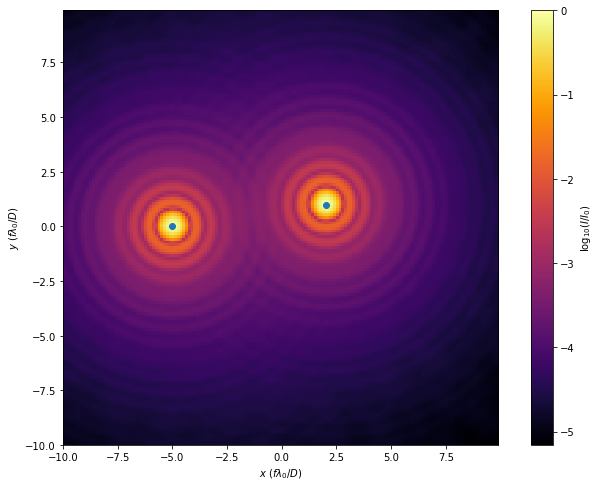

In [7]:
l1 = (loc1 * D/lam).value
l2 = (loc2 * D/lam).value

plt.figure(figsize=(12,8))
im = hp.imshow_field(np.log10(result/result.max()), cmap='inferno', grid_units = (F*lam/D).value)
plt.scatter([l1[0], l2[0]], [l1[1], l2[1]])
plt.colorbar(im, label = r"log$_{10}(I/I_0)$")
plt.xlabel(r"$x$ ($f\lambda_0/D$)")
plt.ylabel(r"$y$ ($f\lambda_0/D$)")

plt.show()